In [ ]:

import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
from dateutil.relativedelta import relativedelta
import time
import gc
import os
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings (action = "ignore")

# Set some options in Jupyter to display datasets.
pd.set_option ('display.max_columns', 200)
pd.set_option ('display.max_rows', 200)

In [ ]:
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

import xgboost as xgb

In [ ]:
# Function for reducing the used memory.
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[: 3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df [col] = df [col] .astype (np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df [col] = df [col] .astype (np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {: 5.2f} Mb ({: .1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:


calendar = pd.read_csv('calendar.csv')
sell_prices = pd.read_csv('sell_prices.csv')
sales_train_validation = pd.read_csv('sales_train_validation.csv')
submission = pd.read_csv('sample_submission.csv')

    
       

calendar = reduce_mem_usage(calendar)
sell_prices = reduce_mem_usage(sell_prices)
sales_train_validation = reduce_mem_usage(sales_train_validation)
submission = reduce_mem_usage(submission)
        
  

Mem. usage decreased to  0.12 Mb ( 41.9% reduction)
Mem. usage decreased to  130.48 Mb ( 37.5% reduction)
Mem. usage decreased to  95.00 Mb ( 78.7% reduction)
Mem. usage decreased to  26.47 Mb ( 84.5% reduction)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Function to merge datasets returning only one dataframe.
def reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 30000000, merge = False):
    
    # Reshaping sales data using melt.
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print ('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_trian_validation = reduce_mem_usage(sales_train_validation)
    
    # Preparing test and validation records.
    test_rows = [row for row in submission['id'] if 'validation' in row]
    val_rows = [row for row in submission['id'] if 'evaluation' in row]
    
    test = submission[submission ['id']. isin(test_rows)]
    val = submission[submission ['id']. isin(val_rows)]
    
    # Renaming the columns.
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921',
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930',
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949',
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958',
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967',
                   'd_1968', 'd_1969']
    
    # Getting only product data and removing duplicate records.
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]. drop_duplicates ()
    
    # Merge with the product table.
    test = test.merge(product, how = 'left', on = 'id')
    val = val.merge(product, how = 'left', on = 'id')
    # Reshaping test and validation data.
    test = pd.melt(test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt(val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # Creating a new column to define training, test and validation data.
    sales_train_validation['part'] = 'train'
    test['part'] = 'test'
    val['part'] = 'val'
    
    # Creating a single dataset with the addition of all training, validation and test records.
    data = pd.concat([sales_train_validation, test, val], axis = 0)
    
    # Removing previous datasets.
    del sales_train_validation, test, val
    
    # Selecting only a few records for training.
    data = data.loc[nrows:]
    
    # Removing validation data.
    data = data[data ['part']!= 'val']
    
    # Performing the merge with calendar and price.
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Final dataset for training has {} rows and {} columns'.format(data.shape [0], data.shape [1]))
    else:
        pass
    
    return data
# Function for handling missing values and transformation of categorical/numeric features
def transform(data):
    
    # Performing treatment on missing values for the categorical features.
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data[feature] .fillna('unknown', inplace = True)
    
    # Performing treatment on missing values for the sell_price feature.
    data['sell_price']. fillna(0, inplace = True)
        
    # Turning features categories into numbers to make predictions.
    encoder = preprocessing.LabelEncoder ()
    data['id_encode'] = encoder.fit_transform(data ['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data


In [ ]:
%%time

# Reshaping and merging datasets.
data = reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, merge = True)

# Calling up the data transformation functions.
data = transform(data)

# Viewing the final dataset header.
data.head()

# Clearing data from memory.
gc.collect()

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to  3226.27 Mb ( 0.0% reduction)
Final dataset for training has 39123050 rows and 21 columns
CPU times: user 3min 20s, sys: 56.9 s, total: 4min 17s
Wall time: 4min 15s


8

In [ ]:
# Checking the start and end date of the dataset.
print(min(data['date']), max(data['date']))

2013-10-08 2016-05-22


In [ ]:
# Selecting only 1 item for testing: FOODS_3_634_WI_2.
df = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand'] > 0) & (data['demand'] <= 15)]

# Selecting only a few columns for analysis and training.
df = df[['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]

# Transforming the date as index.
df = df.set_index('date')

# Viewing the dataset result.
df.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2013-10-09,8,2,0,8,2,30,4,1,3.980469
2013-10-10,5,2,0,8,2,30,4,0,3.980469
2013-10-11,8,2,0,8,2,30,4,1,3.980469
2013-10-12,13,2,0,8,2,30,4,1,3.980469
2013-10-13,10,2,0,8,2,30,4,0,3.980469


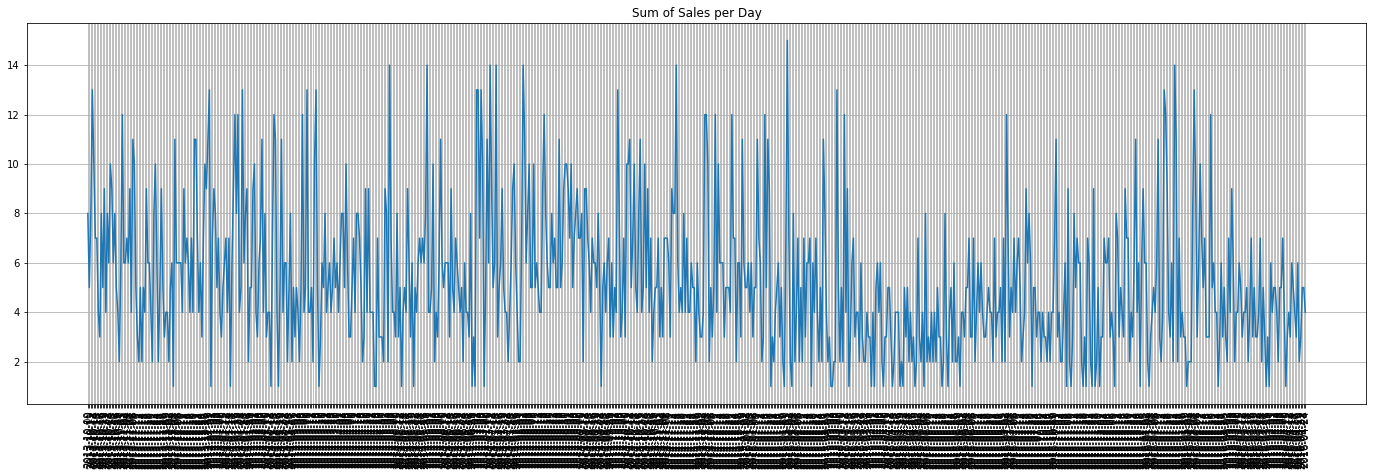

In [ ]:
# Display the sum of sales per day.
plt.figure(figsize=(24, 7))
plt.plot(df['demand'])
plt.title('Sum of Sales per Day')
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

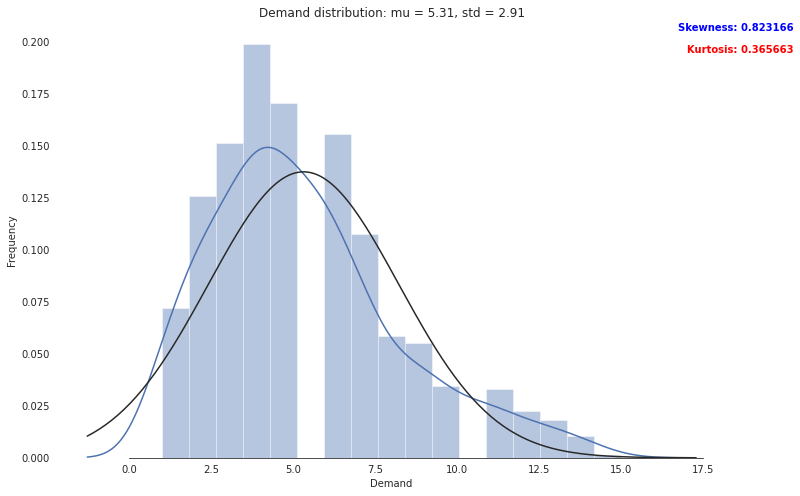

In [ ]:
# Viewing distribution information for the variable "demand".
sns.set_style("white")
sns.set_color_codes(palette = 'deep')
f, ax = plt.subplots(figsize = (12, 8))

# Fit a normal distribution.
mu, std = norm.fit(df['demand'])

# Checking the frequency distribution of the variable "demand".
sns.distplot (df['demand'], color = "b", fit = stats.norm)
ax.xaxis.grid(False)
ax.set(ylabel = "Frequency")
ax.set(xlabel = "Demand")
ax.set(title = "Demand distribution: mu =% .2f, std =% .2f"% (mu, std))
sns.despine(trim = True, left = True)

# Adding Skewness and Kurtosis.
ax.text(x = 1.1, y = 1, transform = ax.transAxes, s = "Skewness:% f"% df ['demand']. skew (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'blue')
ax.text(x = 1.1, y = 0.95, transform = ax.transAxes, s = "Kurtosis:% f"% df ['demand']. kurt (), \
        fontweight = 'demibold', fontsize = 10, verticalalignment = 'top', horizontalalignment = 'right', \
        backgroundcolor = 'white', color = 'red')

plt.show()

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations.
    """
    return np.average(series[-n:])

#  Making predictions for the last 28 days.
moving_average(df, 28)

5.90656001984127

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values.
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values.
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

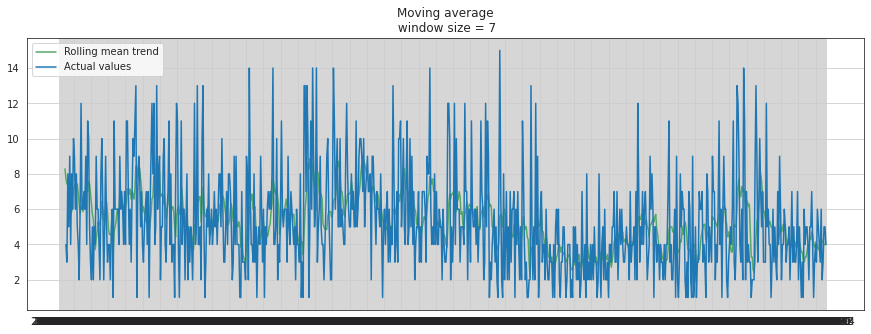

In [ ]:
# Smooth out data using a 7-day window.
plotMovingAverage (df ['demand'], 7)

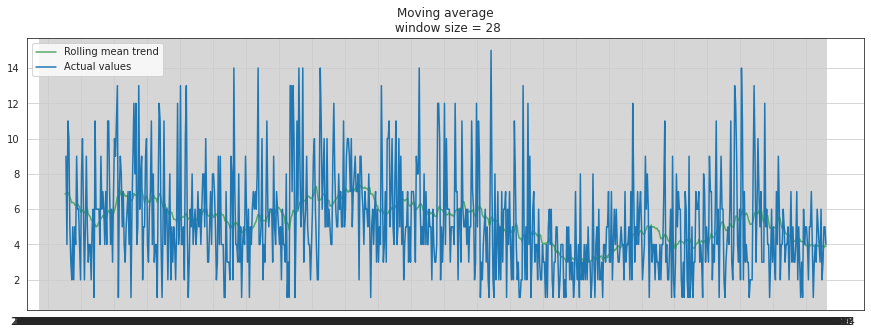

In [ ]:
# Smooth out using a 28-day window.
plotMovingAverage (df ['demand'], 28)

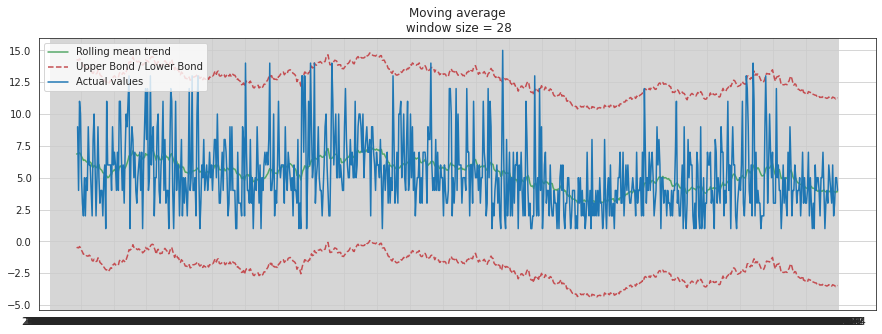

In [ ]:
plotMovingAverage(df['demand'], 28, plot_intervals=True)

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

In [ ]:
weighted_average(df['demand'], [0.6, 0.3, 0.1])

4.9

In [ ]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    # First value is same as series.
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [ ]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

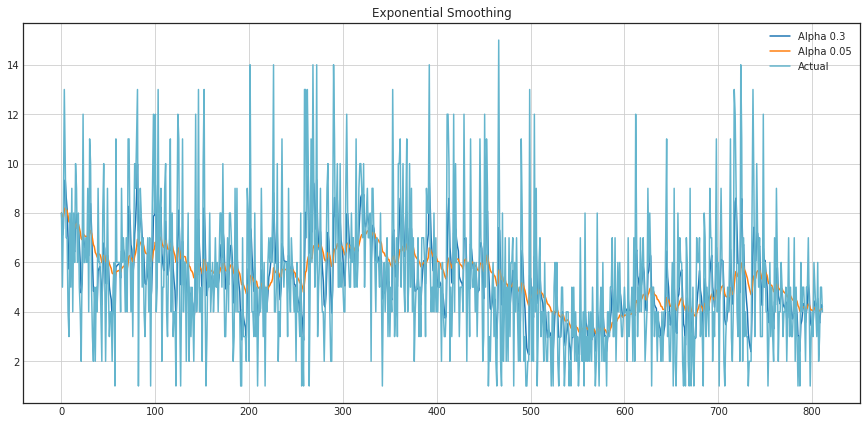

In [ ]:
plotExponentialSmoothing(df['demand'], [0.3, 0.05])

In [ ]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # First value is same as series.
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [ ]:
def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

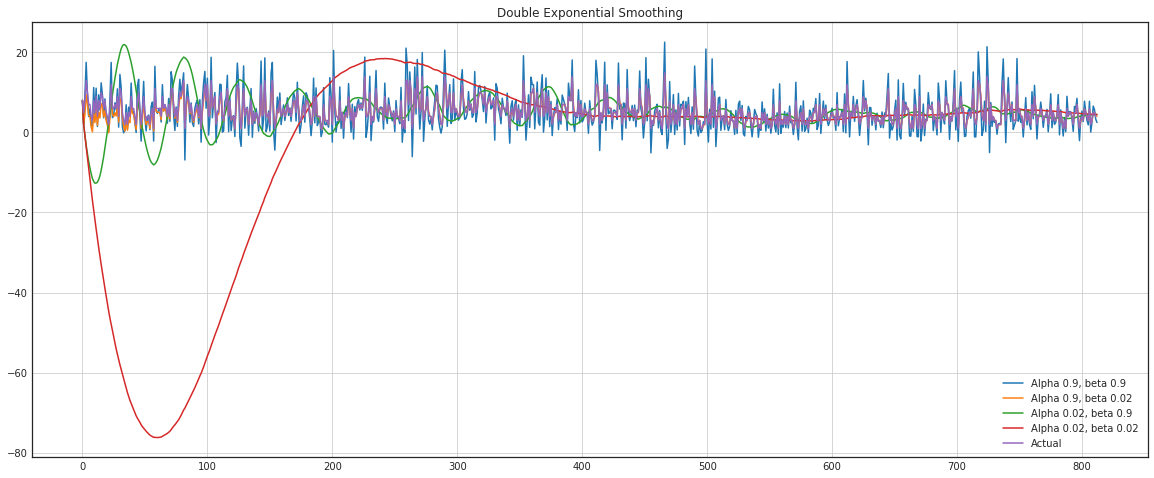

In [ ]:
plotDoubleExponentialSmoothing(df['demand'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method.
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor = 1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series [i + self.slen] - self.series [i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int (len(self.series) / self.slen)
        # Calculate season averages.
        for j in range(n_seasons):
            season_averages.append(sum (self.series[self.slen * j: self.slen * j + self.slen]) / float(self.slen))
        # Calculate initial values.
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals



          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        for i in range(len(self.series) + self.n_preds):
            if i == 0: 
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i% self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result [0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation [0])
                continue
                
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals [i % self.slen])
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val-seasonals[i % self.slen]) + (1-self.alpha) * (smooth + trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta) * trend
                seasonals [i % self.slen] = self.gamma * (val-smooth) + (1-self.gamma) * seasonals [i % self.slen]
                self.result.append(smooth + trend + seasonals [i % self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series [i] - self.result [i])
                                               + (1-self.gamma) * self.PredictedDeviation[-1])
                self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals [i % self.slen])
    

In [ ]:
def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=28):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], 
                            slen=slen, 
                            alpha=alpha, 
                            beta=beta, 
                            gamma=gamma, 
                            n_preds=len(test))
        
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [ ]:
%%time

new_data = df['demand']

# Initializing model parameters alpha, beta and gamma.
x = [0, 0, 0] 

# Minimizing the loss function. 
opt = minimize(timeseriesCVscore, 
               x0=x, 
               args=(new_data, mean_squared_error), 
               method="TNC", 
               bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values.
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# Train the model with them, forecasting for the next 28 days.
model = HoltWinters(new_data, 
                    slen = 28, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 28, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.008429587123283233 0.012599684125113031 0.015188932554576706
CPU times: user 5.63 s, sys: 1.38 ms, total: 5.63 s
Wall time: 5.58 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    
    error = rmse(series.values, model.result[:len(series)])
    plt.title("RMSE: {0:.2f}".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN] * len(series))
        anomalies[series.values < model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values > model.UpperBond[:len(series)]] = \
            series.values[series.values > model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-60, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

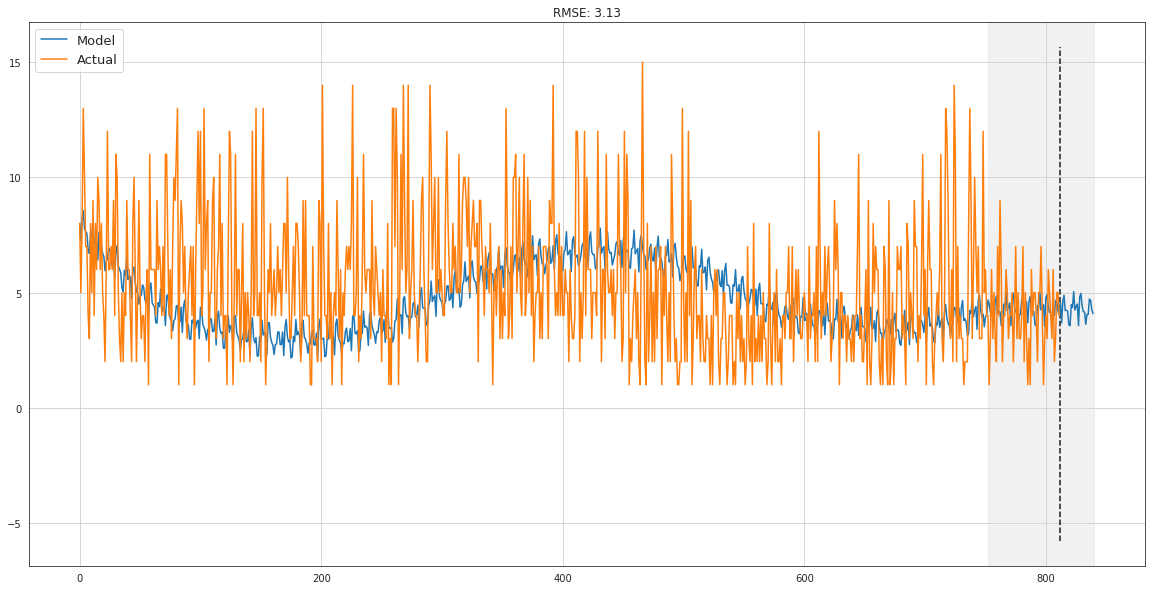

In [ ]:
plotHoltWinters(df['demand'])

In [ ]:
# Create a copy of the original dataset.
new_df = df.copy ()

# Viewing the dataset.
new_df.head ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2013-10-09,8,2,0,8,2,30,4,1,3.980469
2013-10-10,5,2,0,8,2,30,4,0,3.980469
2013-10-11,8,2,0,8,2,30,4,1,3.980469
2013-10-12,13,2,0,8,2,30,4,1,3.980469
2013-10-13,10,2,0,8,2,30,4,0,3.980469


In [ ]:

# Adding features considering the demand delay of 7 to 28 days.
for i in range (7, 29):
     new_df ["lag _ {}". format (i)] = new_df ['demand']. shift (i)

In [ ]:
# Time series cross-validation.
tscv = TimeSeriesSplit (n_splits = 5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
# Set the dependent and independent variables.
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [ ]:
# Split 10% for the test dataset.
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [ ]:
# Instantiating and fitting a linear regression to the time series data.
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modeled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
            error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
    

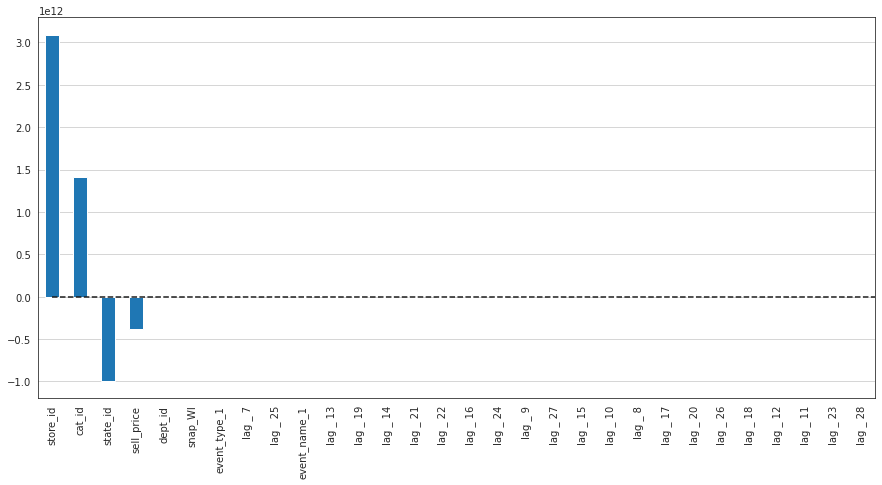

In [ ]:
#plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Copy of the initial dataset.
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

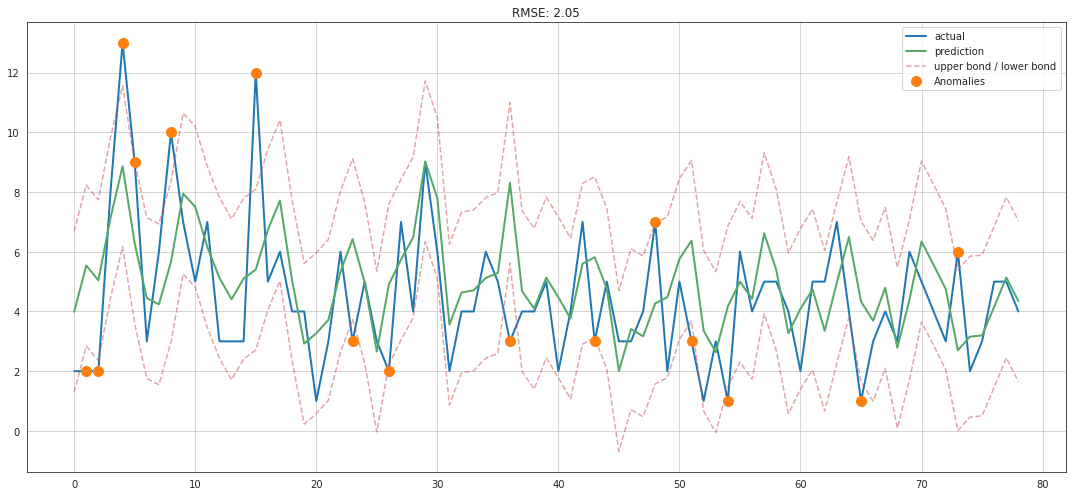

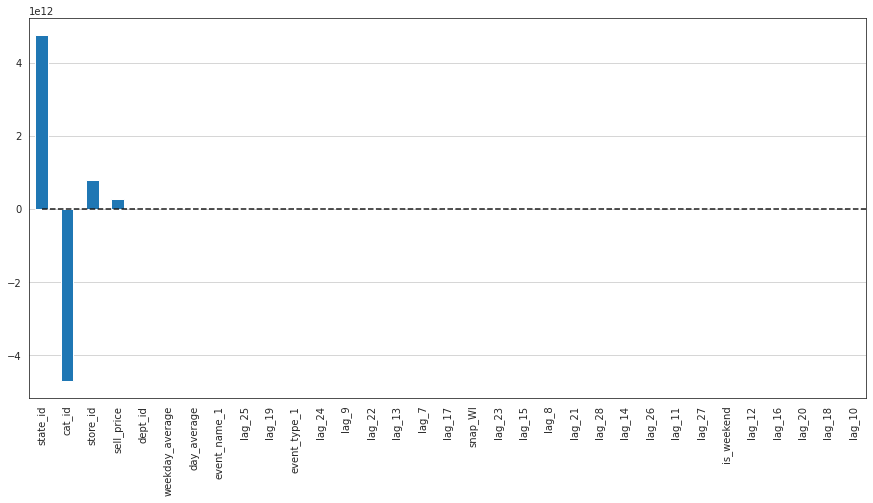

In [ ]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=True)
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

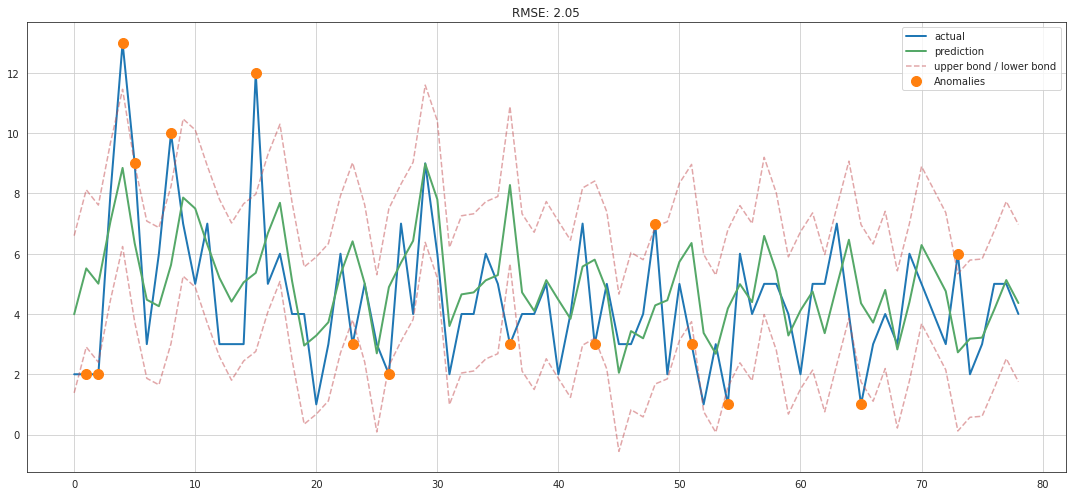

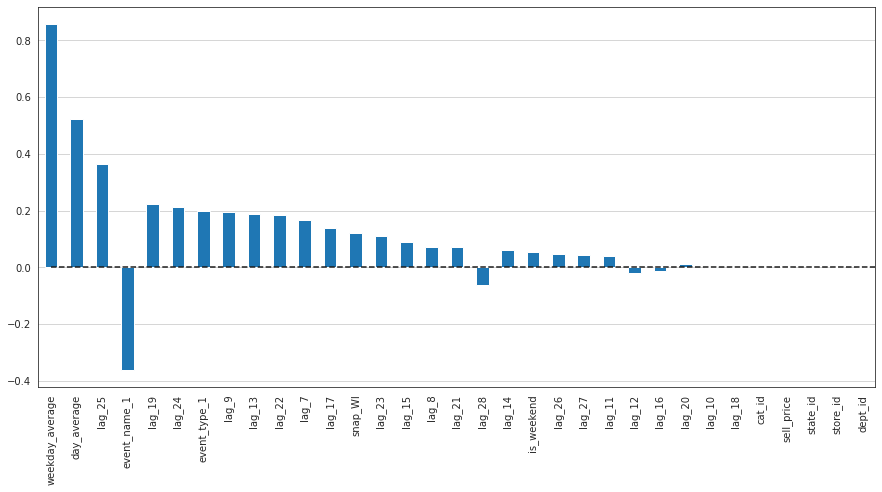

In [ ]:
# Ridge Regression.
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

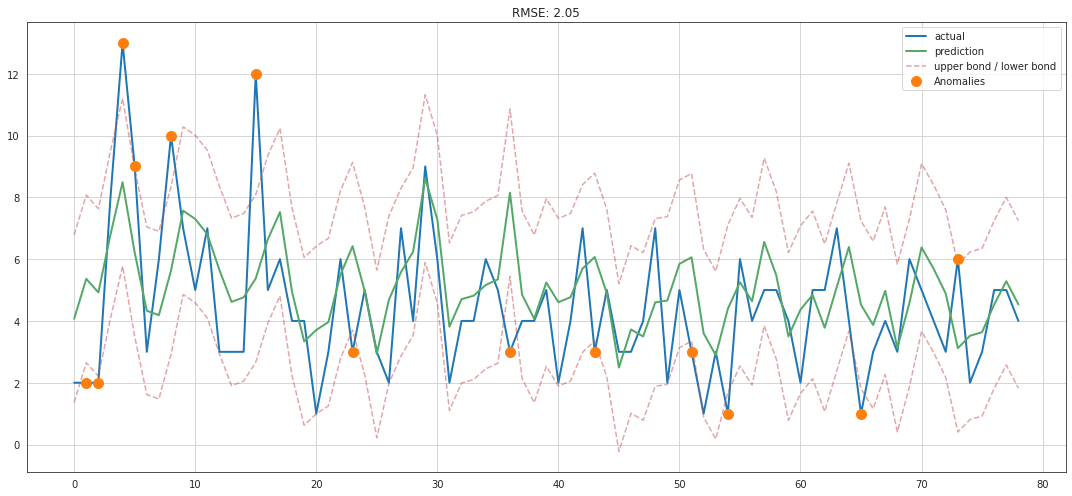

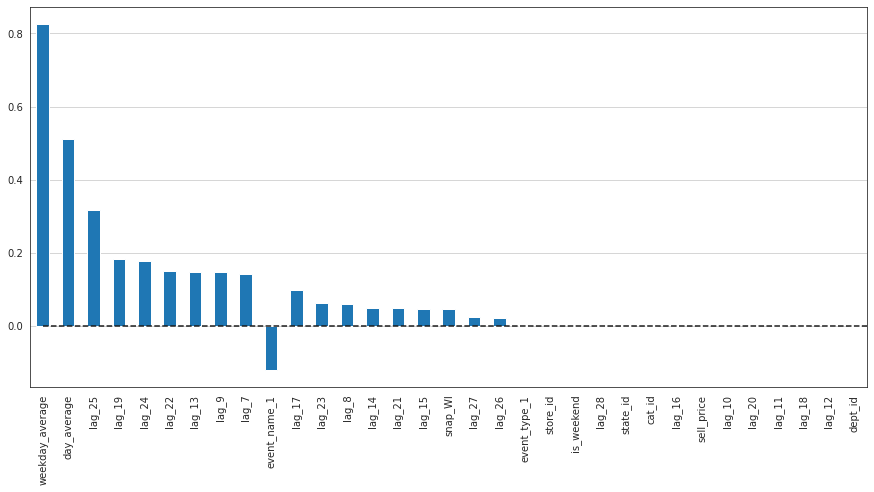

In [ ]:
# Lasso Regression for feature selection.
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(lasso)